In [ ]:
%config Completer.use_jedi = False
%config InlineBackend.figure_formats = ['svg']

# Subclassing `sympy.Expr`

```{autolink-skip}
```

In [ ]:
%pip install -q matplotlib==3.4.2 sympy==1.8

In [ ]:
from abc import abstractmethod
from typing import Callable

import sympy as sp
from helpers import (
    StateTransitionGraph,
    blatt_weisskopf,
    determine_attached_final_state,
    two_body_momentum_squared,
)

The major disadvantage of {doc}`function`, is that there is no way to identify which `Symbol`s are variables and which are parameters. This can be solved by sub-classing from {class}`sympy.core.expr.Expr`.

An example of a class that does this is {class}`~sympy.physics.quantum.spin.WignerD`. There, the implementation of the dynamics expression can be evaluated through a {meth}`~sympy.core.basic.Basic.doit` call. This method can call anything, but {mod}`sympy` seems to follow the convention that it returns an 'evaluated' version of the class itself, where 'evaluated' means that any randomly named method of the class has been called on the `*args` that are implemented through the `__new__` method (the examples below make this clearer).

For our purposes, the follow `DynamicsExpr` base class illustrates the interface that we expect. Here, `evaluate` is where expression is implemented and (just as in {doc}`function`) `from_graph` is the builder method.

In [ ]:
class DynamicsExpr(sp.Expr):
    @classmethod
    @abstractmethod
    def __new__(cls, *args: sp.Symbol, **hints) -> sp.Expr:
        pass

    @abstractmethod
    def doit(self, **hints) -> sp.Expr:
        pass

    @abstractmethod
    def evaluate(self) -> sp.Expr:
        pass

    @classmethod
    @abstractmethod
    def from_graph(cls, graph: StateTransitionGraph, edge_id: int) -> sp.Basic:
        pass

The `__new__` and `doit` methods split the construction from the evaluation of the expression. This allows one to distinguish `variables` and `parameters` and present them as properties:

In [ ]:
class RelativisticBreitWigner(DynamicsExpr):
    def __new__(cls, *args: sp.Symbol, **hints) -> sp.Expr:
        if len(args) != 3:
            raise ValueError(f"3 parameters expected, got {len(args)}")
        args = sp.sympify(args)
        evaluate = hints.get("evaluate", False)
        if evaluate:
            return sp.Expr.__new__(cls, *args).evaluate()  # type: ignore  # pylint: disable=no-member
        return sp.Expr.__new__(cls, *args)

    @property
    def mass(self) -> sp.Symbol:
        return self.args[0]

    @property
    def mass0(self) -> sp.Symbol:
        return self.args[1]

    @property
    def gamma0(self) -> sp.Symbol:
        return self.args[2]

    @property
    def variables(self) -> set[sp.Symbol]:
        return {self.mass}

    @property
    def parameters(self) -> set[sp.Symbol]:
        return {self.mass0, self.gamma0}

    def doit(self, **hints) -> sp.Expr:
        return RelativisticBreitWigner(*self.args, **hints, evaluate=True)

    def evaluate(self) -> sp.Expr:
        return (
            self.gamma0
            * self.mass0
            / (
                self.mass0**2
                - self.mass**2
                - self.gamma0 * self.mass0 * sp.I
            )
        )

    @classmethod
    def from_graph(
        cls, graph: StateTransitionGraph, edge_id: int
    ) -> "RelativisticBreitWigner":
        edge_ids = determine_attached_final_state(graph, edge_id)
        final_state_ids = map(str, edge_ids)
        mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
        particle, _ = graph.get_edge_props(edge_id)
        mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
        gamma0 = sp.Symbol(Rf"\Gamma_{{{particle.latex}}}")
        return cls(mass, mass0, gamma0)

In [ ]:
class RelativisticBreitWignerWithFF(DynamicsExpr):
    def __new__(cls, *args: sp.Symbol, **hints) -> sp.Expr:
        if len(args) != 7:
            raise ValueError(f"7 parameters expected, got {len(args)}")
        args = sp.sympify(args)
        evaluate = hints.get("evaluate", False)
        if evaluate:
            return sp.Expr.__new__(cls, *args).evaluate()  # type: ignore  # pylint: disable=no-member
        return sp.Expr.__new__(cls, *args)

    def doit(self, **hints) -> sp.Expr:
        return RelativisticBreitWignerWithFF(
            *self.args, **hints, evaluate=True
        )

    @property
    def mass(self) -> sp.Symbol:
        return self.args[0]

    @property
    def mass0(self) -> sp.Symbol:
        return self.args[1]

    @property
    def gamma0(self) -> sp.Symbol:
        return self.args[2]

    @property
    def m_a(self) -> sp.Symbol:
        return self.args[3]

    @property
    def m_b(self) -> sp.Symbol:
        return self.args[4]

    @property
    def angular_momentum(self) -> sp.Symbol:
        return self.args[5]

    @property
    def meson_radius(self) -> sp.Symbol:
        return self.args[6]

    def evaluate(self) -> sp.Expr:
        # Computed variables
        q_squared = two_body_momentum_squared(self.mass, self.m_a, self.m_b)
        q0_squared = two_body_momentum_squared(self.mass0, self.m_a, self.m_b)
        ff2 = blatt_weisskopf(
            q_squared, self.meson_radius, self.angular_momentum
        )
        ff02 = blatt_weisskopf(
            q0_squared, self.meson_radius, self.angular_momentum
        )
        width = self.gamma0 * (self.mass0 / self.mass) * (ff2 / ff02)
        width = width * sp.sqrt(q_squared / q0_squared)
        # Expression
        return (
            RelativisticBreitWigner(self.mass, self.mass0, width)
            * self.mass0
            * self.gamma0
            * sp.sqrt(ff2)
        )

    @classmethod
    def from_graph(
        cls, graph: StateTransitionGraph, edge_id: int
    ) -> "RelativisticBreitWignerWithFF":
        edge_ids = determine_attached_final_state(graph, edge_id)
        final_state_ids = map(str, edge_ids)
        mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
        particle, _ = graph.get_edge_props(edge_id)
        mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
        gamma0 = sp.Symbol(Rf"\Gamma_{{{particle.latex}}}")
        m_a = sp.Symbol(f"m_{edge_ids[0]}")
        m_b = sp.Symbol(f"m_{edge_ids[1]}")
        angular_momentum = particle.spin  # helicity formalism only!
        meson_radius = sp.Symbol(Rf"R_{{{particle.latex}}}")
        return cls(
            mass,
            mass0,
            gamma0,
            m_a,
            m_b,
            angular_momentum,
            meson_radius,
        )

The following illustrates the difference with {doc}`function`. First, notice that a class derived from `DynamicsExpr` is still **identifiable** upon construction:

In [ ]:
m, m0, w0 = sp.symbols(R"m m_0 \Gamma")
rel_bw = RelativisticBreitWigner(m, m0, w0)
rel_bw

RelativisticBreitWigner(m, m_0, \Gamma)

```{toggle}
The way in which this expression is rendered in a Jupyter notebook can be changed by overwriting the `_pretty` and/or `_latex` methods.
```

Only once `doit()` is called, is the `DynamicsExpr` converted into a mathematical expression:

In [ ]:
evaluated_bw = rel_bw.doit()
evaluated_bw

\Gamma*m_0/(-I*\Gamma*m_0 - m**2 + m_0**2)

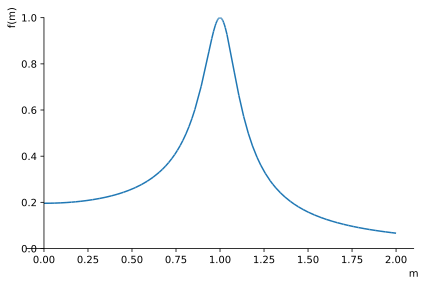

In [ ]:
sp.plot(
    sp.Abs(evaluated_bw.subs({m0: 1, w0: 0.2})),
    (m, 0, 2),
    axis_center=(0, 0),
    ylim=(0, 1),
);

## Decorator

There are a lot of implicit conventions that need to be followed to provide a correct implementation of a `DynamicsExpr`. Some of this may be mitigated by proving some class decorator that can easily construct the `__new__()` and `doit()` methods for you.

In [ ]:
def dynamics_expression(
    n_args: int,
) -> Callable[[type], type[DynamicsExpr]]:
    def decorator(decorated_class: type) -> type[DynamicsExpr]:
        def __new__(cls, *args: sp.Symbol, **hints) -> sp.Expr:
            if len(args) != n_args:
                raise ValueError(
                    f"{n_args} parameters expected, got {len(args)}"
                )
            args = sp.sympify(args)
            evaluate = hints.get("evaluate", False)
            if evaluate:
                return sp.Expr.__new__(cls, *args).evaluate()
            return sp.Expr.__new__(cls, *args)

        def doit(self, **hints) -> sp.Expr:
            return decorated_class(*self.args, **hints, evaluate=True)

        decorated_class.__new__ = __new__
        decorated_class.doit = doit
        return decorated_class

    return decorator

This saves some lines of code:

In [ ]:
@dynamics_expression(n_args=3)
class Gauss(DynamicsExpr):
    @property
    def mass(self) -> sp.Symbol:
        return self.args[0]

    @property
    def mu(self) -> sp.Symbol:
        return self.args[1]

    @property
    def sigma(self) -> sp.Symbol:
        return self.args[2]

    @property
    def variables(self) -> set[sp.Symbol]:
        return {self.mass}

    @property
    def parameters(self) -> set[sp.Symbol]:
        return {self.mu, self.sigma}

    def evaluate(self) -> sp.Expr:
        return sp.exp(-((self.mass - self.mu) ** 2) / self.sigma**2)

    @classmethod
    def from_graph(
        cls, graph: StateTransitionGraph, edge_id: int
    ) -> "RelativisticBreitWigner":
        edge_ids = determine_attached_final_state(graph, edge_id)
        final_state_ids = map(str, edge_ids)
        mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
        particle, _ = graph.get_edge_props(edge_id)
        mass0 = sp.Symbol(Rf"\mu_{{{particle.latex}}}")
        gamma0 = sp.Symbol(Rf"\sigma_{{{particle.latex}}}")
        return cls(mass, mass0, gamma0)

In [ ]:
x, mu, sigma = sp.symbols(R"x \mu \sigma")
Gauss(x, mu, w0)

Gauss(x, \mu, \Gamma)

In [ ]:
Gauss(x, mu, sigma).doit()

exp(-(-\mu + x)**2/\sigma**2)

## Issue with lambdify

It's not possible to plot a `DynamicsExpr` directly as long as no `lambdify` hook has been provided: **`doit()` has to be executed first**.

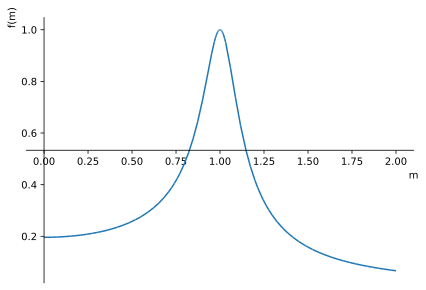

In [ ]:
sp.plot(sp.Abs(rel_bw.subs({m0: 1, w0: 0.2})).doit(), (m, 0, 2));